In [1]:
import networkx as nx
from IPython.display import Image, HTML, display, clear_output
from dataclasses import dataclass
import matplotlib.pyplot as plt
import pandas as pd
from typing import Tuple, Any
import itertools
import numpy as np
import seaborn as sns
from collections import OrderedDict
from datetime import datetime
import scipy
import os
from dataclasses import dataclass, field
from statsmodels.distributions.empirical_distribution import ECDF
from functools import lru_cache
import math
import yaml

In [2]:
import so_ana_doc_worker.so_ana_reporting as so_ana_reporting
from so_ana_sqlalchemy_models.db_deps import prod_db_deps_container, dict_to_es_key
import so_ana_management.management_utils as so_ana_mu
from so_ana_util import data_access
import so_ana_util

# Constants

In [3]:
NR_ITERATE = 10000

# Define relevant helper objects

In [4]:
@dataclass
class ProgressBar:
    heading: str
    progr_str: str = field(default='Progress: {ratio:.4f}%')
    duration_prfx_str: str = field(default='Duration: ')
    width_total_in_px: int = field(default=500)
    height_total_in_px: int = field(default=30)
    bg_color: str = field(default='DodgerBlue')
    txt_color: str = field(default='White')
        
    def take_time_snapshot(self):
        self.curr_time = datetime.now()
    
    def update_progress(self, progress):
        if progress == 0:
            self.take_time_snapshot()
        if isinstance(progress, int):
            progress = float(progress)
        if not isinstance(progress, float):
            progress = 0
        if progress < 0:
            progress = 0
        if progress >= 1:
            progress = 1
            
        clear_output(wait = True)

        width = int(progress * (self.width_total_in_px - 2))
        ratio_txt = self.progr_str.format(ratio=100*progress)
        time_delta_str = self.duration_prfx_str + str(datetime.now()-self.curr_time)
        html_txt = f'<h2>{self.heading}</h2>'
        html_txt += f'<div>{ratio_txt}</div>'
        html_txt += f'<div style="width:{self.width_total_in_px}px;height:{self.height_total_in_px}px;border:1px solid #000;">'
        html_txt += f'<div style="width:{width}px;height:{self.height_total_in_px-2}px;border:1px solid #000;background-color:{self.bg_color};color:{self.txt_color}">'
        html_txt += '</div></div>'
        html_txt += f'<div>{time_delta_str}</div>'
        display(HTML(html_txt))

# Get db connection data

In [5]:
deps = prod_db_deps_container()

In [6]:
all_jobs = so_ana_reporting.ReportingDataAccess.load_all_job_data(deps.conn)
flow_run_id = all_jobs.sort_values('started_at_timest', ascending=False).iloc[0, :]['flow_run_id']

display(HTML(f'<h1>Last flow-run-id is: "{flow_run_id}"</h1>'))
display(HTML('<hr width="85%" align="left">'))
print()

all_steps = so_ana_reporting.ReportingDataAccess.load_all_step_data_for_flow_run_id(  connection=deps.conn,
                                                                                      flow_run_id=flow_run_id)

flow_opts=all_jobs[all_jobs['flow_run_id']==flow_run_id]['flow_opts'].iloc[0]

ROOT_PATH =os.path.join(os.path.join(so_ana_util.PROJ_OUTP_PATH, flow_run_id), 'jupyter_network')

try:
    os.mkdir(ROOT_PATH)
except FileExistsError:
    pass

EXP_PATH_USER_GRAPH = os.path.join(ROOT_PATH, 'user_graph.xlsx')
EXP_PATH_DOC_GRAPH = os.path.join(ROOT_PATH, 'document_graph.xlsx')
EXP_PATH_DISTR =  os.path.join(ROOT_PATH, 'graph_distribution_@GRAPHNAME@.xlsx')
TAG_LABEL=flow_opts['topic']
NR_TOPICS=flow_opts['ml_opts']['num_topics']

display(HTML(f'<h1>Steps for flow-run-id="{flow_run_id}"</h1>'))
display(all_steps.sort_index())
print()
display(HTML(f'<h1>Step results</h1>'))
step_res_dict = {idx: item['result'] for idx, item in all_steps.iterrows()}
print(yaml.dump(step_res_dict))
display(HTML('<hr width="85%" align="left">'))
display(HTML(f'<h1>All jobs available</h1>'))
display(all_jobs)
print()
display(HTML('<h1>flow config</h1>'))
print(yaml.dump(flow_opts))

,flow_name,flow_id,flow_run_id,flow_run_name,step_label,...,result,exit_code,exit_msg,prev_step_lbls,modus
step,,,,,,,,,,,
#1,so-analysis,so-analysis,a9507a44-d173-4de4-99f4-5e8a9c181b96,microservices_20220206,dwnl_microservices_20220206_#1,...,"{'step': '#1', 'label': 'dwnl_microservices_20...",0,None,[],prod
#2,so-analysis,so-analysis,a9507a44-d173-4de4-99f4-5e8a9c181b96,microservices_20220206,dwnl_microservices_20220206_#2,...,"{'step': '#2', 'label': 'dwnl_microservices_20...",0,None,[dwnl_microservices_20220206_#1],prod
#3,so-analysis,so-analysis,a9507a44-d173-4de4-99f4-5e8a9c181b96,microservices_20220206,dwnl_microservices_20220206_#3,...,"{'step': '#3', 'label': 'dwnl_microservices_20...",0,None,"[dwnl_microservices_20220206_#1, dwnl_microser...",prod
#4,so-analysis,so-analysis,a9507a44-d173-4de4-99f4-5e8a9c181b96,microservices_20220206,preproc_microservices_20220206,...,"{'step': '#4', 'label': 'preproc_microservices...",0,None,"[dwnl_microservices_20220206_#1, dwnl_microser...",prod
#5,so-analysis,so-analysis,a9507a44-d173-4de4-99f4-5e8a9c181b96,microservices_20220206,vect_microservices_20220206,...,"{'step': '#5', 'label': 'vect_microservices_20...",0,None,"[dwnl_microservices_20220206_#1, dwnl_microser...",prod
#6,so-analysis,so-analysis,a9507a44-d173-4de4-99f4-5e8a9c181b96,microservices_20220206,ml_opts_microservices_20220206,...,"{'step': '#6', 'step_label': 'ml_opts_microser...",0,None,"[dwnl_microservices_20220206_#1, dwnl_microser...",prod
#7,so-analysis,so-analysis,a9507a44-d173-4de4-99f4-5e8a9c181b96,microservices_20220206,rep_microservices_20220206,...,"[{'step': '#7', 'step_label': 'rep_microservic...",0,None,"[dwnl_microservices_20220206_#1, dwnl_microser...",prod
#8,so-analysis,so-analysis,a9507a44-d173-4de4-99f4-5e8a9c181b96,microservices_20220206,reporting_3f1c9e20-0e35-4ecc-a925-f11d77461f3a,...,"[{'step': '#1', 'label': 'dwnl_microservices_2...",0,None,"[dwnl_microservices_20220206_#1, dwnl_microser...",prod


'#1':
  batch_id: null
  divisor: 1
  exit_code: 0
  label: dwnl_microservices_20220206_#1
  msg: ''
  nr_failure: 0
  nr_success: 7687
  step: '#1'
'#2':
  exit_code: 0
  label: dwnl_microservices_20220206_#2
  msg: ''
  nr_failure: 0
  nr_success: 7687
  step: '#2'
'#3':
  data_class_name_set:
  - QuestionInfo
  exit_code: 0
  label: dwnl_microservices_20220206_#3
  msg: ''
  nr_failure: 0
  nr_success: 7687
  result_class_name_set:
  - ExtractResult
  step: '#3'
'#4':
  data_class_name_set:
  - TokenizationData
  exit_code: 0
  label: preproc_microservices_20220206
  msg: ''
  nr_failure: 0
  nr_success: 7687
  result_class_name_set:
  - TokenizationResult
  step: '#4'
'#5':
  data_class_name_set:
  - BoWData
  exit_code: 0
  label: vect_microservices_20220206
  msg: ''
  nr_failure: 0
  nr_success: 7687
  result_class_name_set:
  - BoWResult
  step: '#5'
'#6':
  artefact_key: LDA_model_data
  artefact_value:
    base_path: C:\Users\d91109\Documents\work\git\MBA_github\StackOverflow

,description,flow_name,flow_id,flow_run_id,flow_run_name,...,step_2_info,use_step_label,use_step_step,from_email,user_agent
0,analysis of posts on domain driven design,so-analysis,60a79a45-1edb-485b-9002-0e0a2bf1b29d,c4a1fe66-f096-478f-9b6a-3a47dfe78bdc,ddd_20220204,...,"{'#1': {'step': '#1', 'label': 'dwnl_ddd_20220...",None,None,Holger.Bernigau@gmx.de,Software Engineering Research@University of St...
1,analysis of posts on microservices,so-analysis,9edb7508-820f-4de4-8d62-2d26135a4a55,a9507a44-d173-4de4-99f4-5e8a9c181b96,microservices_20220206,...,"{'#1': {'step': '#1', 'label': 'dwnl_microserv...",None,None,Holger.Bernigau@gmx.de,Software Engineering Research@University of St...


description: analysis of posts on microservices
download_opts:
  batch_count: 1
  download_rate_delay: 2.0
  error_retry_delay: 400.0
  max_dwnl_errors_per_batch: 20
  opts_description: download of sample data
  opts_label: dwnl_microservices_20220206
ml_opts:
  nr_passes: 50
  num_topics: 10
  opts_description: standard implementation of ml model integration
  opts_label: ml_opts_microservices_20220206
  storage_location: ML_OPTS
  test_fraction: 0
  val_fraction: 0
pre_proc_opts:
  base_content: all
  filter_gensim_stopwords: true
  opts_description: standard implementation of stemming
  opts_label: preproc_microservices_20220206
  own_stopword_lst: []
  to_lower_case: true
  use_lemmatizer: wordnet
preproc_batch_count: 10
rep_opts:
  LDAvis_base_location: reports
  opts_description: LDA vis and word cloud
  opts_label: rep_microservices_20220206
  wc_base_location: reports
stack_exchange_type: stackoverflow
topic: microservices
use_step: null
vect_opts:
  filter_no_above: 1.0
  filt

# Define relevant graph object 

In [7]:
@dataclass(frozen=True)
class DocInfo:
    post_id: int
        
@dataclass(frozen=True)
class UserInfo:
    user_url: str
               
        
def multi_graph_2_weighted_graph(gr):
    if gr.is_directed():
        new_gr = nx.DiGraph(name='Reduced' + gr.graph['name'])
    else:
        new_gr = nx.Graph(name='Reduced' + gr.graph['name'])
    
    for node in gr.nodes:
        new_gr.add_node(node)
    
    for edge in gr.edges:
        if new_gr.has_edge(edge[0], edge[1]):
            new_gr[edge[0]][edge[1]]['weight'] += 1
        else:
            new_gr.add_edge(edge[0], edge[1], weight=1)
            
    return new_gr

def reverse(gr):
    res = gr.reverse(copy=True)
    res.graph['name'] = 'Reversed' + res.graph['name']
    return res

    
class DocUserGraph:
    
    def __init__(self):
        self.G = nx.MultiDiGraph()
        
    def add_document(self,post_id, user_url, topic_tuple, answ_user_url_lst):
        doc_node = DocInfo(post_id=post_id)
        user_node = UserInfo(user_url=user_url)
        self.G.add_node(doc_node, topic_weights=np.array(topic_tuple))
        self.G.add_node(user_node)
        self.G.add_edge(doc_node, user_node)
        for item in answ_user_url_lst:
            answ_user_node = UserInfo(user_url=item)
            self.G.add_node(answ_user_node)
            self.G.add_edge(answ_user_node, doc_node)
    
    def _get_user_weight(self, user_info):
        weight = None
        for ng in  itertools.chain(self.G.successors(user_info), self.G.predecessors(user_info)):
            if weight is None:
                weight = np.copy(self.G.nodes[ng]['topic_weights'])
            else:
                weight += self.G.nodes[ng]['topic_weights']         
                
        return weight / np.sum(weight)
    
    @property        
    def user_response_graph(self):
        new_gr = nx.MultiDiGraph(name='UserResponseGraph')
        for node in self.G:
            if isinstance(node, UserInfo):
                weight = self._get_user_weight(node)
                new_gr.add_node(node, topic_weights=weight)
                for ng1 in self.G.successors(node):
                    for ng2 in self.G.successors(ng1):
                        if not ng2 == UserInfo(None):
                            weight2 = self._get_user_weight(ng2)
                            new_gr.add_node(ng2, topic_weights=weight2)
                            new_gr.add_edge(node, ng2)             
        return new_gr
    
    @property 
    def document_contr_graph(self):
        new_gr = nx.MultiGraph(name='DocumentUserSharedGraph')
        node_set = set()
        for node in self.G:
            if isinstance(node, DocInfo):
                weight = self.G.nodes[node]['topic_weights']
                new_gr.add_node(node, topic_weights=weight)
                node_set.add(node)
                for ng1 in itertools.chain(self.G.successors(node), self.G.predecessors(node)):
                    for ng2 in itertools.chain(self.G.successors(ng1), self.G.predecessors(ng1)):
                        if not ng2 in node_set:
                            weight2 = self.G.nodes[ng2]['topic_weights']
                            new_gr.add_node(ng2, weight_vector=weight2)
                            new_gr.add_edge(node, ng2)
        return new_gr
        

# Construct basic graph

In [8]:
# get document iterator for relevant step
doc_iterator = data_access.get_doc_iterator(connection=deps.conn,
                                            d2es_obj=deps.d2es,
                                            step_label=all_steps.loc['#3']['step_label'],
                                            format = 'all_#3',
                                            ml_tags=None
                    )

nr_docs = len(doc_iterator)

# create relevant graph
graph = DocUserGraph()

query = 'select user_url from so_ana_doc_worker.page_meta_info ' \
        'where step=%(step)s and step_label=%(step_label)s and post_id=%(post_id)s'

query2 = 'select topic_id, topic_weight from so_ana_analysis.topic_distribution '\
         'where step=%(step)s and step_label=%(step_label)s and post_id=%(post_id)s order by topic_id asc'

progr_bar = ProgressBar('Constructing document-user graph...')

for i, qu in enumerate(doc_iterator):
    if i % 10 == 0:
        progr_bar.update_progress(i/nr_docs)
    res = deps.conn.execute(query,   {'step': '#1',
                                      'step_label': all_steps.loc['#1']['step_label'],
                                      'post_id': qu.post_id
                             }).fetchone()[0]
    weight_res = {item[0]: item[1] for item in  deps.conn.execute(query2,   { 'step': '#7',
                                                                              'step_label': all_steps.loc['#7']['step_label'],
                                                                              'post_id': qu.post_id
                                                                     }
                                                          )
                 }
    graph.add_document(post_id=qu.post_id, user_url=res,  topic_tuple=tuple([weight_res.get(i, 0) for i in range(NR_TOPICS)]), answ_user_url_lst=[answ.user_url for answ in qu.answers])

progr_bar.update_progress(1.0)

# Load relevant data into pandas data frames "user_response_data" and "doc_response_data"

In [9]:
def user_iterator(user_response_graph):
    for node in user_response_graph.nodes():
        wv = user_response_graph.nodes[node]['topic_weights']
        in_deg = user_response_graph.in_degree(node)
        out_deg = user_response_graph.out_degree(node)
        yield [node.user_url, in_deg, out_deg, out_deg-in_deg] + wv.tolist()

        
def doc_iterator(doc_graph):
        for node in doc_graph.nodes():
            wv = doc_graph.nodes[node]['topic_weights']
            yield [node.post_id, doc_graph.degree(node)] + wv.tolist()

    
    
user_response_graph = graph.user_response_graph        
user_response_data = pd.DataFrame.from_records(user_iterator(user_response_graph), columns=['user', 'in degree', 'out degree', 'degree difference'] + [f'weight {i}' for i in range(NR_TOPICS)])

display(HTML('<h1>User response graph</h1>'))
display(user_response_data.head())

doc_graph = graph.document_contr_graph
doc_response_data = pd.DataFrame.from_records(doc_iterator(doc_graph), columns=['document', 'degree'] + [f'weight {i}' for i in range(NR_TOPICS)])

display(HTML('<h1>Doc contribution graph</h1>'))
display(doc_response_data.head())




,user,in degree,out degree,degree difference,weight 0,...,weight 5,weight 6,weight 7,weight 8,weight 9
0,/users/12891037/ruchi,1,0,-1,0.001100,...,0.001101,0.063505,0.277413,0.286921,0.001101
1,/users/10454736/tushar-mahajan,0,12,12,0.000870,...,0.057487,0.124607,0.088461,0.160894,0.056723
2,/users/9107502/0x1c1b,3,0,-3,0.000535,...,0.044053,0.093078,0.056181,0.000535,0.035421
3,/users/1240671/liviu,1,0,-1,0.001970,...,0.001971,0.001971,0.593683,0.091024,0.001970
4,/users/1192435/timothy-shenton,1,0,-1,0.001517,...,0.729417,0.001518,0.001518,0.147199,0.001518


,document,degree,weight 0,weight 1,weight 2,...,weight 5,weight 6,weight 7,weight 8,weight 9
0,62760043,12,0.001100,0.001101,0.233147,...,0.001101,0.063505,0.277413,0.286921,0.001101
1,64004151,13,0.000635,0.534035,0.347571,...,0.000635,0.000635,0.000635,0.000635,0.070406
2,65277688,12,0.001970,0.001971,0.147129,...,0.001971,0.001971,0.593683,0.091024,0.001970
3,62347503,12,0.001517,0.001518,0.064577,...,0.729417,0.001518,0.001518,0.147199,0.001518
4,62828643,12,0.000489,0.143979,0.055139,...,0.000489,0.058562,0.076593,0.000489,0.171194


# Augment node level graph data

In [10]:
class AugmentedMapper:
    
    def __init__(self, DC):
        self.DC = DC
        self.mapping_dict = {}
       
    def __call__(self, x):
        return self.mapping_dict[self.DC(x)]     

class HashedReturn:
    
    def __init__(self, rel_func):
        self.rel_func = rel_func
        self._res = None
        self.key_hsh = ''
        self.val_hsh = ''
        self.gr_name = ''
        
    def __call__(self, gr, **kwargs):
        recalc = (self._res is None) or (self.key_hsh != hash(tuple(kwargs.keys()))) or (self.val_hsh != hash(tuple(kwargs.values()))) or (self.gr_name != gr.graph['name'])
        self.key_hsh =  hash(tuple(kwargs.keys()))
        self.val_hsh = hash(tuple(kwargs.values()))
        self.gr_name = gr.graph['name']
        if recalc:
            self._res = self.rel_func(gr, **kwargs)
        return self._res
    
def get_projection(f, pos):
    def _inner(*args, **kwargs):
        return f(*args, **kwargs)[pos]
    return _inner         
        

def augment_centralities(df, graph):
    red_graph =  multi_graph_2_weighted_graph(graph)
    gr_name = graph.graph['name']
    res_dict = {}
    if gr_name == 'UserResponseGraph':
        aug_mapper = AugmentedMapper(UserInfo)
        rel_label = 'user'
        hsh_hits_func = HashedReturn(nx.algorithms.link_analysis.hits_alg.hits)
        
        lbl_lst = [ ('centrality_in_degree',  nx.algorithms.centrality.in_degree_centrality, {}),
                    ('centrality_out_degree',  nx.algorithms.centrality.out_degree_centrality, {}),
                    ('centrality_eigenvector',  nx.algorithms.centrality.eigenvector_centrality, dict(weight='weight', tol=1.0e-6)),
                    ('centrality_page_rank',  nx.algorithms.link_analysis.pagerank_alg.pagerank, dict(alpha=0.85, weight='weight', tol=1.0e-6)),
                    ('centrality_hits_hubs',  get_projection(hsh_hits_func, 0), {}),
                    ('centrality_hits_authorities',  get_projection(hsh_hits_func, 1), {}),
                    ('centrality_harmonic',  nx.algorithms.centrality.harmonic_centrality, {})
                  ]
    elif gr_name == 'DocumentUserSharedGraph':
        aug_mapper = AugmentedMapper(DocInfo)
        rel_label = 'document'
        lbl_lst = [ ('centrality_degree',  nx.algorithms.centrality.degree_centrality, {}),
                    ('centrality_eigenvector',  nx.algorithms.centrality.eigenvector_centrality, dict(weight='weight', tol=1.0e-6)),
                    ('centrality_page_rank',  nx.algorithms.link_analysis.pagerank_alg.pagerank, dict(alpha=0.85, weight='weight', tol=1.0e-6)),
                    ('centrality_harmonic',  nx.algorithms.centrality.harmonic_centrality, {})
                  ]
    elif gr_name == 'ReversedUserResponseGraph':
        lbl_lst = [ ('centrality_reversed_page_rank',  nx.algorithms.link_analysis.pagerank_alg.pagerank, dict(alpha=0.85, weight='weight', tol=1.0e-6))]
        rel_label = 'user'
        aug_mapper = AugmentedMapper(UserInfo)
        
    for label, alg, kwargs in lbl_lst:
        print(f'calculating "{label}" for graph "{gr_name}"...')
        res_dict[label] = alg(red_graph, **kwargs)

    for label, rel_dict in res_dict.items():
        print(f'starting {label} for graph {gr_name}')
        aug_mapper.mapping_dict = rel_dict
        df[label] = df[rel_label].map(aug_mapper)
    return df

for rel_data, rel_gr in [(doc_response_data, doc_graph), (user_response_data, user_response_graph), (user_response_data, reverse(user_response_graph))]:
    gr_name = rel_gr.graph['name']
    display(HTML(f'<h2>{gr_name}</h2>'))
    rel_data = augment_centralities(rel_data, rel_gr)  
    display(rel_data.head()) 

calculating "centrality_degree" for graph "DocumentUserSharedGraph"...
calculating "centrality_eigenvector" for graph "DocumentUserSharedGraph"...
calculating "centrality_page_rank" for graph "DocumentUserSharedGraph"...
calculating "centrality_harmonic" for graph "DocumentUserSharedGraph"...
starting centrality_degree for graph DocumentUserSharedGraph
starting centrality_eigenvector for graph DocumentUserSharedGraph
starting centrality_page_rank for graph DocumentUserSharedGraph
starting centrality_harmonic for graph DocumentUserSharedGraph


,document,degree,weight 0,weight 1,weight 2,...,weight 9,centrality_degree,centrality_eigenvector,centrality_page_rank,centrality_harmonic
0,62760043,12,0.001100,0.001101,0.233147,...,0.001101,0.001587,0.000007,0.000189,829.049206
1,64004151,13,0.000635,0.534035,0.347571,...,0.070406,0.001719,0.000008,0.000196,863.642857
2,65277688,12,0.001970,0.001971,0.147129,...,0.001970,0.001587,0.000007,0.000189,829.049206
3,62347503,12,0.001517,0.001518,0.064577,...,0.001518,0.001587,0.000007,0.000189,829.049206
4,62828643,12,0.000489,0.143979,0.055139,...,0.171194,0.001587,0.000007,0.000189,829.049206


calculating "centrality_in_degree" for graph "UserResponseGraph"...
calculating "centrality_out_degree" for graph "UserResponseGraph"...
calculating "centrality_eigenvector" for graph "UserResponseGraph"...
calculating "centrality_page_rank" for graph "UserResponseGraph"...
calculating "centrality_hits_hubs" for graph "UserResponseGraph"...
calculating "centrality_hits_authorities" for graph "UserResponseGraph"...
calculating "centrality_harmonic" for graph "UserResponseGraph"...
starting centrality_in_degree for graph UserResponseGraph
starting centrality_out_degree for graph UserResponseGraph
starting centrality_eigenvector for graph UserResponseGraph
starting centrality_page_rank for graph UserResponseGraph
starting centrality_hits_hubs for graph UserResponseGraph
starting centrality_hits_authorities for graph UserResponseGraph
starting centrality_harmonic for graph UserResponseGraph


,user,in degree,out degree,degree difference,weight 0,...,centrality_eigenvector,centrality_page_rank,centrality_hits_hubs,centrality_hits_authorities,centrality_harmonic
0,/users/12891037/ruchi,1,0,-1,0.001100,...,3.516771e-11,0.000055,-0.000000,0.000004,1.0
1,/users/10454736/tushar-mahajan,0,12,12,0.000870,...,2.197982e-12,0.000051,0.000159,-0.000000,0.0
2,/users/9107502/0x1c1b,3,0,-3,0.000535,...,3.318952e-10,0.000102,-0.000000,0.000014,3.5
3,/users/1240671/liviu,1,0,-1,0.001970,...,3.516771e-11,0.000055,-0.000000,0.000004,1.0
4,/users/1192435/timothy-shenton,1,0,-1,0.001517,...,3.516771e-11,0.000055,-0.000000,0.000004,1.0


calculating "centrality_reversed_page_rank" for graph "ReversedUserResponseGraph"...
starting centrality_reversed_page_rank for graph ReversedUserResponseGraph


,user,in degree,out degree,degree difference,weight 0,...,centrality_page_rank,centrality_hits_hubs,centrality_hits_authorities,centrality_harmonic,centrality_reversed_page_rank
0,/users/12891037/ruchi,1,0,-1,0.001100,...,0.000055,-0.000000,0.000004,1.0,0.000061
1,/users/10454736/tushar-mahajan,0,12,12,0.000870,...,0.000051,0.000159,-0.000000,0.0,0.000443
2,/users/9107502/0x1c1b,3,0,-3,0.000535,...,0.000102,-0.000000,0.000014,3.5,0.000061
3,/users/1240671/liviu,1,0,-1,0.001970,...,0.000055,-0.000000,0.000004,1.0,0.000061
4,/users/1192435/timothy-shenton,1,0,-1,0.001517,...,0.000055,-0.000000,0.000004,1.0,0.000061


 # Plot histograms

Kennzahlen


,degree
count,7564.000000
mean,13.023268
std,28.578255
min,0.000000
0.1%,0.000000
1%,0.000000
5%,0.000000
10%,0.000000
20%,0.000000
30%,0.000000


skewness: 3.2896975049144284
kurtosis: 12.791479185984931


Kennzahlen


,in degree
count,10838.000000
mean,0.802547
std,1.405162
min,0.000000
0.1%,0.000000
1%,0.000000
5%,0.000000
10%,0.000000
20%,0.000000
30%,0.000000


skewness: 8.580014350248888
kurtosis: 229.66142994306293


Kennzahlen


,out degree
count,10838.000000
mean,0.802547
std,2.714515
min,0.000000
0.1%,0.000000
1%,0.000000
5%,0.000000
10%,0.000000
20%,0.000000
30%,0.000000


skewness: 20.764597501901154
kurtosis: 617.3446633444671


<Figure size 432x288 with 0 Axes>

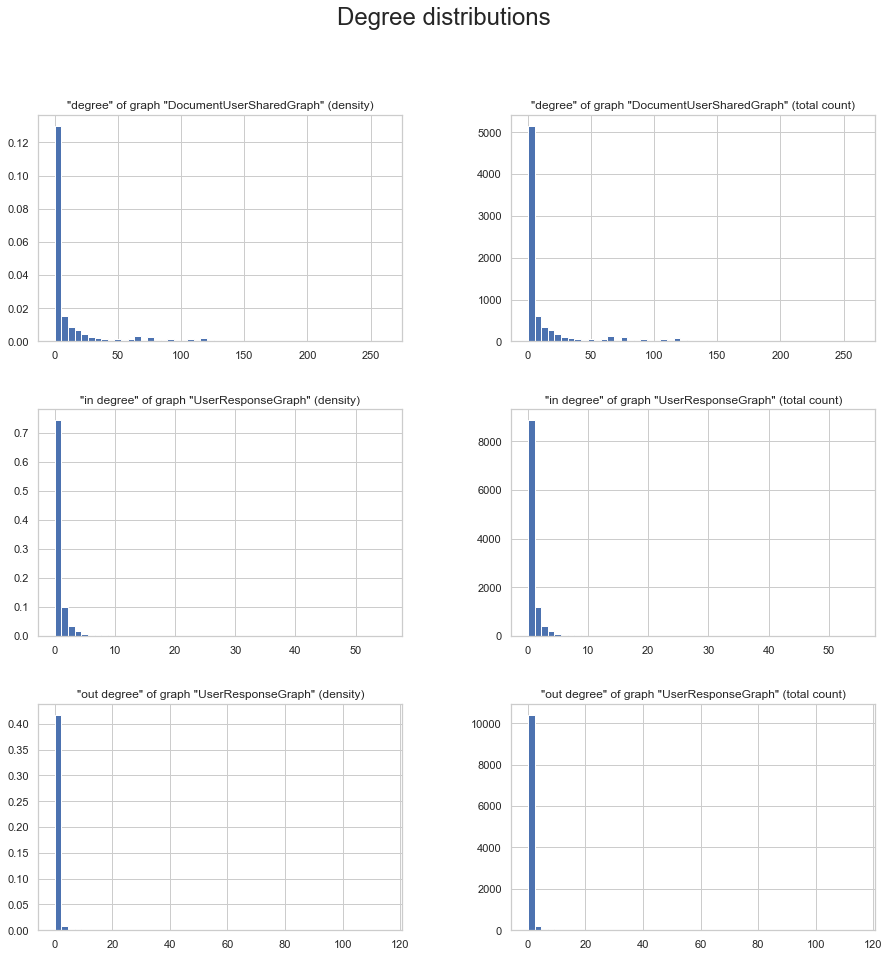

In [11]:
sns.set_theme(style="whitegrid")
sns.despine()

fig1, f1_axes = plt.subplots(ncols=2, nrows=3, constrained_layout=True, figsize=(15, 15))
plt.suptitle('Degree distributions', fontsize=24)

for i, (rel_data, lbl, gr_name) in enumerate(
                                                [(doc_response_data, 'degree', doc_graph.graph['name']), 
                                                 (user_response_data, 'in degree', user_response_graph.graph['name']), 
                                                 (user_response_data, 'out degree', user_response_graph.graph['name'])
                                                ]
                                            ):
    rel_txt = f'"{lbl}" of graph "{gr_name}"'
    display(HTML(f'<h2>Plotting histogram for distribution of ' + rel_txt + '</h2>'))
    for j, bool_density in enumerate([True, False]):
        rel_data[[lbl]].hist(bins=50, density=bool_density, ax = f1_axes[i, j])
        f1_axes[i, j].set_title(rel_txt + (' (density)' if bool_density else ' (total count)'))

    print('Kennzahlen')
    display(rel_data[[lbl]].describe(percentiles=[.001, 0.01, 0.05, 0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.95, .99, 0.999]))
    descr = scipy.stats.describe(rel_data[lbl])
    for attri in ['skewness', 'kurtosis']:
        print(f'{attri}: {getattr(descr, attri)}')

# Export node level graph data

In [12]:
user_response_data.to_excel(EXP_PATH_USER_GRAPH)
doc_response_data.to_excel(EXP_PATH_DOC_GRAPH)

# Calculate key metrics for relevant graphs

In [13]:
display(HTML(f'<h1>Key metrics of graphs</h1>'))
for gr in (graph.G, user_response_graph, doc_graph, multi_graph_2_weighted_graph(user_response_graph), multi_graph_2_weighted_graph(doc_graph)):
    gr_name = gr.graph.get('name', 'FullDocumentUserGraph')
    display(HTML(f'<h2>{gr_name}</h2>'))
    nr_nodes = gr.number_of_nodes()
    nr_edges = gr.number_of_edges()
    print('number of nodes: ', nr_nodes)
    print('number of edges: ', nr_edges)
    print('average degree: ', nr_edges/nr_nodes)
    if gr_name in ('UserResponseGraph', 'ReducedUserResponseGraph', 'FullDocumentUserGraph'):
        print('Strongly connected components: ', nx.number_strongly_connected_components(gr))
        print('Weakly connected components: ', nx.number_weakly_connected_components(gr))
    elif gr_name in ('DocumentUserSharedGraph', 'ReducedDocumentUserSharedGraph'):
        print('Connected components: ', nx.number_connected_components(gr))
        

number of nodes:  18402
number of edges:  16689
average degree:  0.9069122921421585
Strongly connected components:  17812
Weakly connected components:  3346


number of nodes:  10838
number of edges:  8698
average degree:  0.8025465953127884
Strongly connected components:  10838
Weakly connected components:  3417


number of nodes:  7564
number of edges:  49254
average degree:  6.511634056054997
Connected components:  3346


number of nodes:  10838
number of edges:  8580
average degree:  0.791658977671157
Strongly connected components:  10838
Weakly connected components:  3417


number of nodes:  7564
number of edges:  47759
average degree:  6.313987308302486
Connected components:  3346


# Calculate average cosine similarity and randomized empirical distribution of cosine similarity

In [14]:
class CosSimCalculator:
    
    def __init__(self, graph):
        self.graph = graph
        nr_nodes = graph.number_of_nodes()
        for node in graph.nodes():
            nr_weights = graph.nodes[node]['topic_weights'].shape[0]
            break
        self.weight_array = np.zeros(shape=(nr_nodes, nr_weights), dtype=float)
        self.node2posdict = {}
        for i, node in enumerate(graph.nodes()):
            self.node2posdict[node] = i
            for j in range(nr_weights):
                self.weight_array[i, j] = graph.nodes[node]['topic_weights'][j]
        
        self.edge_list = []
        for edge in graph.edges():
            self.edge_list.append((self.node2posdict[edge[0]], self.node2posdict[edge[1]]))
        self.nodepair_2_value_dict = {}
        
    @property
    def nr_edges(self):
        return len(self.edge_list)
    
    @property
    def nr_nodes(self):
        return self.weight_array.shape[0]
    
    @property
    def nr_weights(self):
        return self.weight_array.shape[1]
    
    def get_cos_sim(self, i, j):
        a = self.weight_array[i]
        b = self.weight_array[j]
        return np.dot(a, b) / (np.linalg.norm(a)*np.linalg.norm(b))
    
    def __call__(self, permut_array = None):
        if permut_array is None:
            permut_array = np.arange(self.nr_nodes)
        sum_of_cos = 0.0
        for e1, e2 in self.edge_list:
            i = permut_array[e1]
            j = permut_array[e2]
            if i<=j:
                key = (i, j)
            else:
                key = (j, i)
            new_cos_sim = self.nodepair_2_value_dict.get(key, 0)
            if new_cos_sim == 0:
                new_cos_sim = self.get_cos_sim(i, j)
                self.nodepair_2_value_dict[key] = new_cos_sim
            sum_of_cos += new_cos_sim
        
        return sum_of_cos / self.nr_edges
        
@dataclass
class SimilarityCalculationResult:
    graph: Any
    NR_ITERATE: int = 100
    res_avg_cos_sim: float = 0.0
    res_emp_cos_sim_dist: pd.DataFrame = None
        
    def calculate_emp_distr(self, progr_bar):
        cos_sim_calc = CosSimCalculator(self.graph)
        self.res_avg_cos_sim = cos_sim_calc()
        nr_nodes = cos_sim_calc.nr_nodes
        
        res_lst = []
        for i in range(self.NR_ITERATE):
            rnd_perm = np.random.permutation(nr_nodes)
            progr_bar.update_progress(i/self.NR_ITERATE)
            res_lst.append(cos_sim_calc(rnd_perm))
        progr_bar.update_progress(1.0)
        self.res_emp_cos_sim_dist = pd.DataFrame(res_lst, columns=['random cosine similarity'])
         
#generate calculation results
cos_sim_res_lst = []
for gr in [user_response_graph, doc_graph]: 
    new_res = SimilarityCalculationResult(graph = gr, NR_ITERATE = NR_ITERATE)
    gr_name = gr.graph['name']
    progr_bar = ProgressBar(f'Calculating results for graph "{gr_name}"...')
    new_res.calculate_emp_distr(progr_bar)
    cos_sim_res_lst.append(new_res)

#output most average cosine similarity and its quantile within the emirical distribution
display(HTML('<h1>Results</h1>'))
for res in cos_sim_res_lst:
    gr_name = res.graph.graph['name']
    display(HTML(f'<h2>Graph "{gr_name}"</h2>'))
    print('Average cosine similarity of connected documents: ', res.res_avg_cos_sim)
    emp_dist = ECDF(res.res_emp_cos_sim_dist['random cosine similarity'])
    print('Average cosine similarity equates to the following quantile of empirical distribution: ', emp_dist(res.res_avg_cos_sim))



Average cosine similarity of connected documents:  0.8602017595862976
Average cosine similarity equates to the following quantile of empirical distribution:  1.0


Average cosine similarity of connected documents:  0.4924709785578996
Average cosine similarity equates to the following quantile of empirical distribution:  1.0


# Eport Graph data

In [15]:
for res in cos_sim_res_lst:
    res.res_emp_cos_sim_dist.to_excel(EXP_PATH_DISTR.replace('@GRAPHNAME@', res.graph.graph['name']))

Average cosine similarity:  0.8602017595862976
Corresponding quantile in empirical distribution:  1.0
     -> Assortativity result is highly significant
VA-Index:  0.999970295291605


,random cosine similarity
count,10000.000000
mean,0.390489
std,0.003621
min,0.377599
0.1%,0.379657
1%,0.382038
5%,0.384512
10%,0.385843
20%,0.387433
30%,0.388583


skewness: -0.002989316152367473
kurtosis: -0.07894938134079066


Average cosine similarity:  0.4924709785578996
Corresponding quantile in empirical distribution:  1.0
     -> Assortativity result is highly significant
VA-Index:  0.9997894050100086


,random cosine similarity
count,10000.000000
mean,0.321988
std,0.003499
min,0.308716
0.1%,0.311700
1%,0.313937
5%,0.316256
10%,0.317502
20%,0.319028
30%,0.320135


skewness: 0.04721419206560775
kurtosis: 0.005294794258126956


<Figure size 432x288 with 0 Axes>

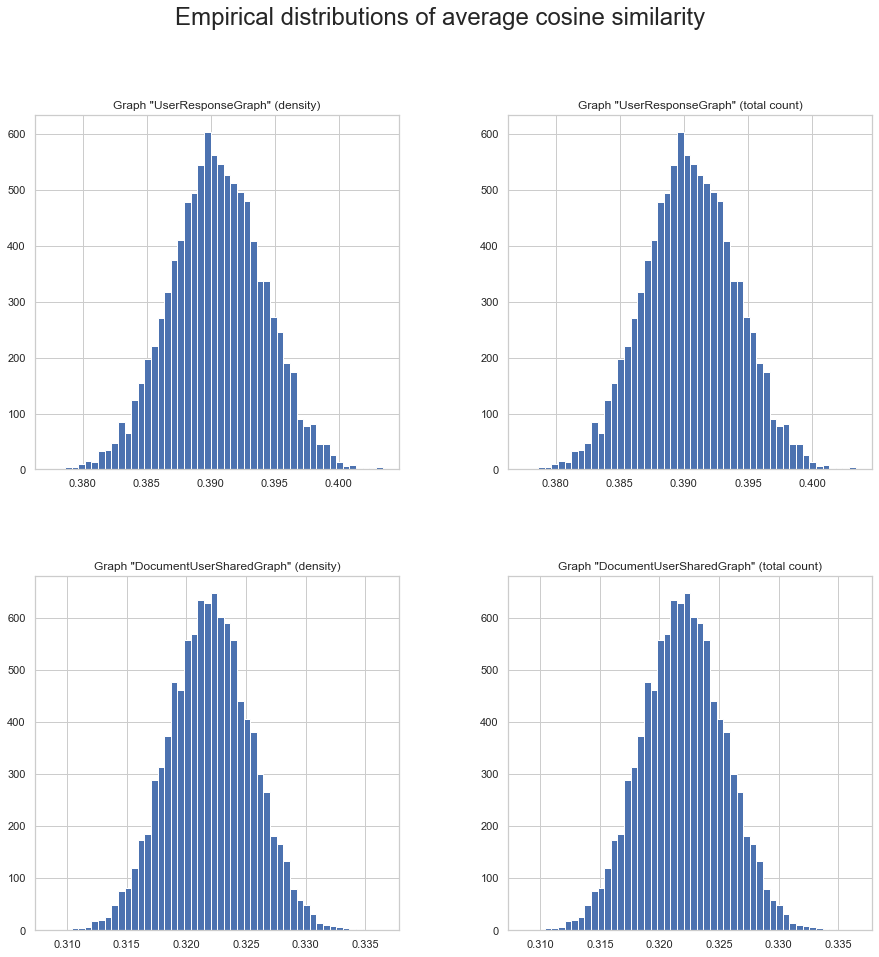

In [16]:
display(HTML('<h1>Key metrics of empirical cosine similarity distribution</h1>'))
sns.set_theme(style="whitegrid")
sns.despine()

fig2, f2_axes = plt.subplots(ncols=2, nrows=len(cos_sim_res_lst), constrained_layout=True, figsize=(15, 15), squeeze=False)
plt.suptitle('Empirical distributions of average cosine similarity', fontsize=24)

for i, res in enumerate(cos_sim_res_lst):
    gr_name = res.graph.graph['name']
    display(HTML(f'<h2>Graph "{gr_name}"</h2>'))
    for j, density_bool in enumerate([True, False]):
        res.res_emp_cos_sim_dist.hist(bins=50, ax = f2_axes[i, j])
        f2_axes[i, j].set_title(f'Graph "{gr_name}" ' + ('(density)' if density_bool else '(total count)'))

    print(f'Average cosine similarity: ',  res.res_avg_cos_sim)
    emp_dist = ECDF(res.res_emp_cos_sim_dist['random cosine similarity'])
    e_qu = emp_dist(res.res_avg_cos_sim)
    print('Corresponding quantile in empirical distribution: ', e_qu)
    if e_qu > 0.975 or e_qu < 0.025:
        txt = 'highly significant'
    elif e_qu > 0.95 or e_qu < 0.05:
        txt = 'significant'
    else:
        txt = 'not significant'
    print('     -> Assortativity result is ' + txt)
    descr_pd = res.res_emp_cos_sim_dist.describe(percentiles=[.001, 0.01, 0.05, 0.1,.2,.3,.4,.5,.6,.7,.8,.9, 0.95, .99, 0.999])
    d_for_VA =  (res.res_avg_cos_sim - descr_pd.loc['mean', 'random cosine similarity'])/descr_pd.loc['std', 'random cosine similarity']
    alpha_for_VA = d_for_VA/math.sqrt(d_for_VA*d_for_VA + 1.0)
    print('VA-Index: ', alpha_for_VA)
    display(descr_pd)
    descr = scipy.stats.describe(res.res_emp_cos_sim_dist['random cosine similarity'])
    for attri in ['skewness', 'kurtosis']:
        print(f'{attri}: {getattr(descr, attri)}')